In [1]:
import pandas as pd
import numpy as np
import random

import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import manifold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gensim

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

import transformers

import cv2
from cv2 import xfeatures2d
from cv2 import imread
from cv2 import drawKeypoints

import os
from os import listdir
os.environ["TF_KERAS"]='1'

In [2]:
print('pandas version :', pd.__version__, '\n')
print('numpy version :', np.__version__, '\n')
print('matplotlib version :', matplotlib.__version__, '\n')
print('seaborn version :', sns.__version__, '\n')
print('sklearn version :', sklearn.__version__, '\n')
print('nltk version :', nltk.__version__, '\n')
print('gensim version :', gensim.__version__, '\n')
print('tensorflow version :', tf.__version__, '\n')
print('transformers version :', transformers.__version__, '\n')
print('cv2 version :', cv2.__version__)

pandas version : 1.2.4 

numpy version : 1.21.4 

matplotlib version : 3.3.4 

seaborn version : 0.11.2 

sklearn version : 1.0.2 

nltk version : 3.6.1 

gensim version : 4.1.2 

tensorflow version : 2.8.0 

transformers version : 4.17.0 

cv2 version : 4.5.5


# Fonctions

In [3]:
def transformation(text, del_sw=True, lem=True):
    """
    Prend du texte et le tokenise en supprimant les caractères qui ne sont pas
    alphanumériques. Donne ensuite la possibilité de supprimer les stopwords
    (mots peu ou pas porteurs d'information) en langue anglaise. Enfin,
    donne la possibilité de faire de la lemmatisation pour n'avoir que la
    forme canonique des mots. Retourne le texte transformé.

            Parameters :
                text : texte à transformer.
                del_sw : Si True, les stopwords sont supprimés. Sinon, ils ne
                         sont pas supprimés.
                lem : Si True, on lemmatise les mots. Sinon, aucune lemmatisation.
    """
    # Tokenisation de nos textes
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    word_tokens = tokenizer.tokenize(text)
    lw = [w.lower() for w in word_tokens]

    # On regarde si on souhaite supprimer des stopwords ou non
    if del_sw == True:
        # On prend la liste des stopwords anglais et on filtre nos textes
        stop_w = list(set(stopwords.words('english')))
        filtered_w = [w for w in lw if not w in stop_w]
        sw = [w for w in filtered_w if len(w) > 2]

        # On regarde si on veut garder seulement la base d'un mot
        if lem == True:
            lemmatizer = WordNetLemmatizer()
            lem_w = [lemmatizer.lemmatize(w) for w in sw]  
            transformed_text = ' '.join(lem_w)

        elif lem == False:
            transformed_text = ' '.join(sw)

        else:
            print("Erreur de saisie : lemmatization ne prend que True ou False comme valeur.")
            
    # On recommence sans les stopwords
    elif del_sw == False:

        if lem == True:
            lemmatizer = WordNetLemmatizer()
            lem_w = [lemmatizer.lemmatize(w) for w in lw]  
            transformed_text = ' '.join(lem_w)

        elif lem == False:
            transformed_text = ' '.join(lw)

        else:
            print("Erreur de saisie : lemmatization ne prend que True ou False comme valeur.")

    else:
        print("Erreur de saisie : stop_words ne prend que True ou False comme valeur.")

    return transformed_text

In [4]:
def reduc_clustering(features, perplex=30, info=True):
    """
    Réduit les dimensions des données fournies en entrée par un t-SNE.
    Prend ensuite ces données afin de réaliser un clustering (KMeans).
    Si demandé, affiche le nombre d'élément présent dans chacun des clusters ainsi créé.
    Retourne les données réduites et les labels des clusters.

            Parameters :
                features : données que l'on veut réduire.
                perplex : Perplexité à utiliser pour le t-SNE.
                info : Si True, affiche le nombre d'élément par cluster, rien sinon.
    """
    t0 = time.time()
    num_labels = len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=perplex, n_iter=2000, 
                         init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=24)
    clusters = cls.fit_predict(X_tsne)
    
    unique, counts = np.unique(cls.labels_, return_counts=True)
    t1 = time.time()
    time_round = np.round(t1 - t0, 0)
    
    if info == True:
        print(f'Nombre de valeurs pour nos {num_labels} clusters :\n', dict(zip(unique, counts)), '\n')
        print(f'Time : {time_round} secondes')
    
    return X_tsne, clusters


def ARI_TSNE_visuel(clusters, info=True):
    """
    Prend le clustering réalisé précédemment et renomme les clusters selon
    la catégorie la plus représentative dudit cluster. Calcule ensuite le
    score ARI entre nos vraies catégories et les catégories prédites. Enfin,
    affiche si demandé le nuage des points mettant en couleur les vraies catégories
    et le nuage de points mettant en couleur les catégories prédites.
    Retourne le score ARI.

            Parameters :
                clusters : labels des données que l'on a obtenus du clustering.
                info : Si True, affiche les nuages de points des catégories
                       vraies et prédites. Affiche aussi le score ARI.
    """
    # On va regarder la catégorie la mieux représentée par cluster
    data['clusters'] = clusters
    
    list_cluster_to_cat = []

    for cat in l_cat:
        sub_df = data[['product_category_tree', 'clusters']]
        category = sub_df[sub_df['product_category_tree'] == cat].value_counts()
        list_cluster_to_cat.append(category.index[0])

    list_cluster_to_cat = sorted(list_cluster_to_cat, key=lambda tup: tup[1])

    # On réutilise notre labelencoder pour revenir à des valeurs numériques
    list_test = []

    for row in data.index:
        for i in range(7):
            if data.loc[row, 'clusters'] == i:
                list_test.append(list_cluster_to_cat[i][0])
    
    data['cluster_to_cat'] = list_test
    
    data['cluster_encoded'] = labelencoder.transform(data['cluster_to_cat'])
    
    labels = data['cluster_encoded']
    
    # On peut maintenant calculer le score ARI
    ARI = np.round(adjusted_rand_score(data['product_category_tree'], data['cluster_encoded']), 4)
    
    # Représentation graphique de nos clusters
    if info == True:
        fig = plt.figure(figsize=(25, 11))

        ax = fig.add_subplot(121)
        scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
        ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categories",
                  fontsize=15)
        plt.title('Représentation des catégories par catégories réelles', fontsize=20)

        ax = fig.add_subplot(122)
        scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
        plt.title('Représentation des catégories par clusters', fontsize=20)

        plt.show()
        print("ARI : ", ARI)
        
    return ARI

In [5]:
def feature_USE_fct(sentences, b_size):
    """
    Prend du texte et le transforme en vecteur. Si la taille de nos sous-parties (b_size)
    n'est pas égale à l'ensemble de nos données, concaténe toutes nos sous-parties.
    Retourne le texte en entrée sous forme de vecteur.

            Parameters :
                sentences : le texte à transformer
                b_size : taille de nos sous-parties (batch_size)
    """
    batch_size = b_size

    # On va utiliser embed sur toutes nos sous-parties (batch)
    for step in range(len(sentences) // batch_size):
        idx = step*batch_size
        feat = embed(sentences[idx:idx + batch_size])

        # Si len(sentences) = batch_size (= 1050)
        if step == 0 :
            features = feat
        # Sinon on concatène nos batch de features
        else :
            features = np.concatenate((features, feat))

    return features

In [6]:
# Fonction de préparation des phrases
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    """
    Prend du texte, un tokenizer et la taille maximale des séquences.
    Sépare le texte en token et l'encode. Retourne les input_ids
    (l'index des tokens des séquences), les token_type_ids (indique si
    le segment étudié appartient à la phrase A ou la phrase B), les
    attention_mask (les tokens que l'on doit prendre en compte ou non) et
    regroupe toutes ces informations dans bert_inp_tot.

            Parameters :
                sentences : le texte à transformer.
                bert_tokenizer : le tokenizer à utiliser.
                max_length (int) : taille maximale des séquences.
    """
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []
    
    # Encodage des phrases en ajoutant les tokens spéciaux de BERT
    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size):
    """
    Prend un modèle, le type spécifique du modèle souhaité, du texte et
    la taille de nos sous-parties (batch_size) à utiliser. Spécifie le
    tokenizer à utiliser (bert_tokenizer) et crée les features en utilisant
    le modèle BERT. Retourne le texte en entrée sous forme de vecteur.
    
            Parameters :
                model : modèle à utiliser
                model_type : type du modèle à utiliser ("bert-base-uncased" par exemple)
                sentences : le texte à transformer
                b_size : taille de nos sous-parties (batch_size)
    """
    batch_size = b_size
    bert_tokenizer = transformers.AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    # On utilise le modèle pour toutes nos sous-parties
    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        text_preprocessed = {"input_word_ids" : input_ids, 
                             "input_mask" : attention_mask, 
                             "input_type_ids" : token_type_ids}
        outputs = model(text_preprocessed)
        last_hidden_states = outputs['sequence_output']
        
        # Si len(sentences) = batch_size (= 1050)
        if step == 0 :
            last_hidden_states_tot = last_hidden_states

        # Sinon on concatène nos batch de features
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot, last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert

In [7]:
def build_histogram(kmeans, des, image_num):
    """
    Prend un algorithme de clustering (kmeans), des descripteurs ainsi
    que l'index de l'image. L'objectif est de regrouper les descripteurs
    entre eux pour avoir des "visual bags of words". On compte le nombre
    de descripteur dans chaque cluster et pour chaque image. Retourne
    l'histogramme de l'image

            Parameters :
                kmeans : algorithme de clustering utilisé sur nos descripteurs
                des : les descripteurs à utiliser par image
                image_num : index de l'images
    """
    
    # Création de nos clusters et des histogrammes vides
    cluster = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    
    # Nombre de descripteurs
    nb_des=len(des)

    if nb_des==0: print('Problème histogramme image  : ', image_num)

    # On remplit nos histogrammes
    # On pondère par le nombre de descripteurs
    for i in cluster:
        hist[i] += 1.0/nb_des
        
    return hist

# Nettoyage du jeu de données

In [8]:
# On charge nos données
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [9]:
# On regarde les premières lignes
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [10]:
# Dimension de notre jeu de données
df.shape

(1050, 15)

In [11]:
# On regarde nos colonnes
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [12]:
# On regarde si nous avons des valeurs manquantes
df.isnull().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

A priori là les valeurs manquantes ne vont pas poser problème pour nos analyses sur les descriptions des articles ainsi que leur image.

In [13]:
# Vérifions si nous avons des doublons
df.duplicated().sum()

0

In [14]:
# On regarde quelques valeurs afin de mieux comprendre certaines colonnes
for col in ['product_name', 'product_category_tree', 'description', 'product_specifications']:
    print(col, ':', df[col][0], '\n')

product_name : Elegance Polyester Multicolor Abstract Eyelet Door Curtain 

product_category_tree : ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."] 

description : Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning 

In [15]:
# Nous allons juste garder quelques colonnes
data = df[['uniq_id', 'product_name', 'brand', 'product_category_tree', 'image', 'description']]

In [16]:
# On supprime les avertissements nous indiquant que l'on change les valeurs de notre jeu de données d'origine
pd.options.mode.chained_assignment = None

Enfin, on crée un dictionnaire vide pour pouvoir stocker nos résultats.

In [17]:
dict_result = {}

## Nos catégories

Nous allons maintenant s'occuper de nos catégories afin de ne pas en avoir un nombre trop important.

In [18]:
# On regarde quelques valeurs afin de mieux comprendre notre colonne
for val in random.sample(range(0, data.shape[0]), 5):
    print(data['product_category_tree'][val], '\n')

["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"] 

["Kitchen & Dining >> Coffee Mugs >> Printland Coffee Mugs"] 

["Home Decor & Festive Needs >> Wall Decor & Clocks >> Paintings >> Wallmantra Paintings"] 

["Watches >> Wrist Watches >> Sonata Wrist Watches"] 

["Baby Care >> Infant Wear >> Baby Girls' Clothes >> Shorts & Trousers >> Trousers >> Feetje Trousers"] 



In [19]:
# On ne va garder que la première catégorie générale
for val in range(0, data.shape[0]):
    cat = data['product_category_tree'][val].split('>')[0]
    cat = cat.replace('["', '')
    cat = cat[:-1]
    data['product_category_tree'][val] = cat

In [20]:
# Nos catégories :
data['product_category_tree'].value_counts()

Home Decor & Festive Needs    150
Kitchen & Dining              150
Watches                       150
Beauty and Personal Care      150
Computers                     150
Home Furnishing               150
Baby Care                     150
Name: product_category_tree, dtype: int64

In [21]:
# On transforme nos catégories en valeurs numériques
labelencoder = LabelEncoder()

data['categories'] = labelencoder.fit_transform(data['product_category_tree'])
    
features = labelencoder.classes_

# On garde nos catégories sous forme de liste
l_cat = features.tolist()

# Et on garde nos catégories qui ont été transformées avec le LabelEncoder
y_cat_num = data['categories']

# Clustering via nos descriptions d'articles

Nous allons voir si nous pouvons réaliser de bons clustering de nos produits en utilisant :
- CountVectorizer,
- TfidfVectorizer,
- Word2Vec,
- Universal Sentence Encoder (USE) et
- Bidirectional Encoder Representations from Transformers (BERT).

## CountVectorizer

In [22]:
# On crée une copie de notre jeu de données pour les modèles de bag-of-words
data_bow = data.copy()

On crée une colonne de textes transformés pour avoir nos bags-of-words: on supprime les stopwords et on fait une lemmatization.

In [23]:
# On supprime les stopwords et on fait une lemmatization
data_bow['bow'] = data_bow['description'].apply(lambda x : transformation(x))

In [24]:
# Création du bag of words (CountVectorizer)
countvectorizer = CountVectorizer()

cv_fit = countvectorizer.fit(data_bow['bow'])

cv_transform = countvectorizer.transform(data_bow['bow'])

In [25]:
print("CountVectorizer : ")
print("-----------------")

# On réduit nos dimensions et on fait un K-Means
X_tsne, clusters = reduc_clustering(cv_transform)

CountVectorizer : 
-----------------
Nombre de valeurs pour nos 7 clusters :
 {0: 174, 1: 141, 2: 252, 3: 75, 4: 147, 5: 136, 6: 125} 

Time : 8.0 secondes


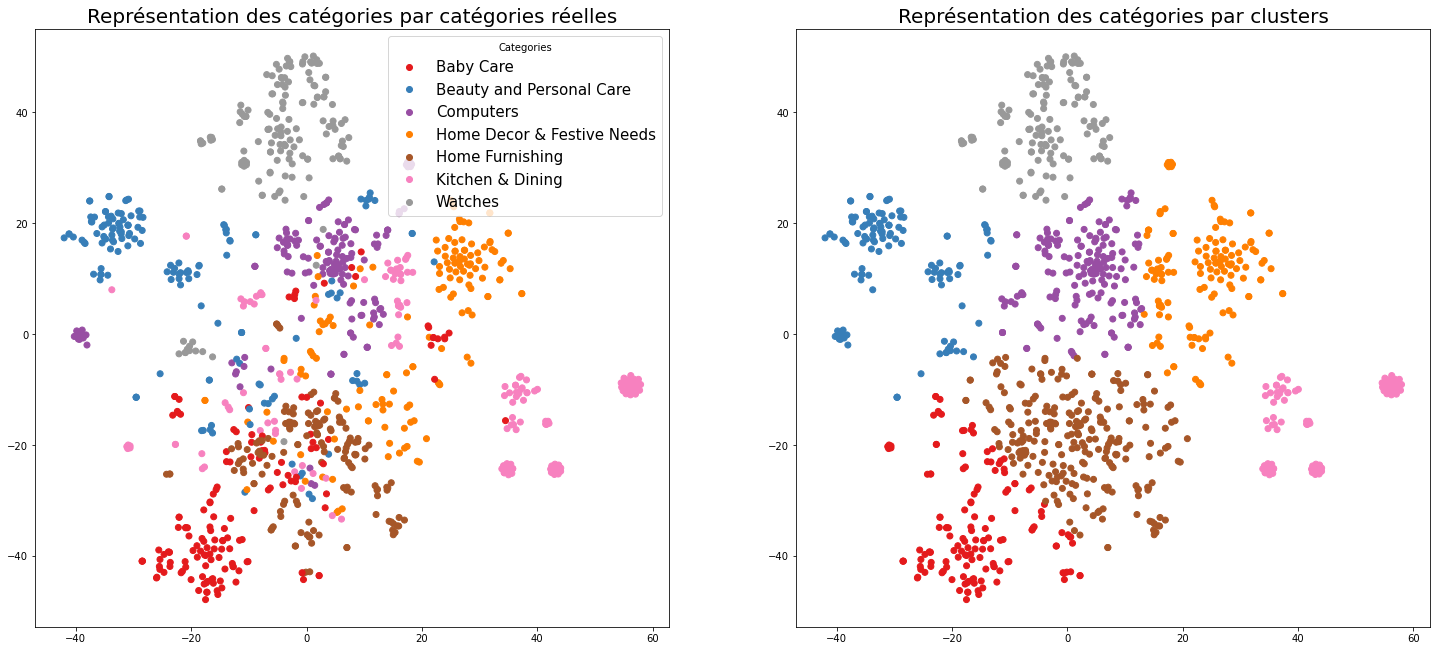

ARI :  0.4202


In [26]:
# Représentation visuelle et calcul de l'Adjusted Rand Score
ARI_count = ARI_TSNE_visuel(clusters)

In [27]:
# Calcul du score de silhouette
silhouette_count = round(silhouette_score(X_tsne, clusters), 4)

print('Silhouette Score de CountVectorizer: {:.2f}'.format(silhouette_count))

Silhouette Score de CountVectorizer: 0.44


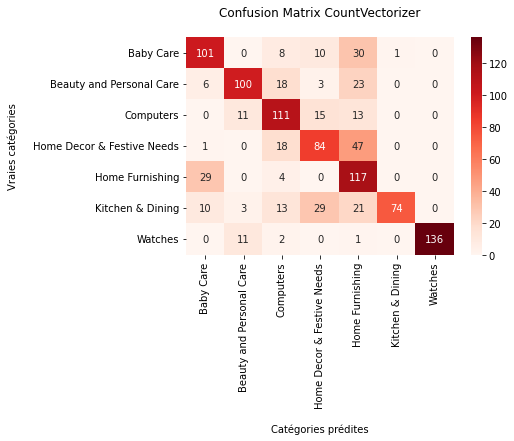

In [28]:
# Matrice de confusion pour mieux voir nos erreurs
matrix_count = confusion_matrix(data['categories'], data['cluster_encoded'])

ax = sns.heatmap(matrix_count, annot=True, cmap='Reds', fmt='g')

ax.set_title('Confusion Matrix CountVectorizer\n');
ax.set_xlabel('\nCatégories prédites')
ax.set_ylabel('Vraies catégories\n');

# On ordonne nos catégories
ax.xaxis.set_ticklabels(sorted(data['product_category_tree'].unique()), rotation=90)
ax.yaxis.set_ticklabels(sorted(data['product_category_tree'].unique()), rotation=0)

plt.show()

In [29]:
# Calcul  de l'Accuracy
accuracy_count = round(accuracy_score(data['categories'], data['cluster_encoded']), 4)*100

print('Accuracy de CountVectorizer: {:.2f}%'.format(accuracy_count))

Accuracy de CountVectorizer: 68.86%


In [30]:
# On met à jour notre dictionnaire de résultats
ARI_count = ARI_count*100
silhouette_count = silhouette_count*100

dict_result.update({'CountVectorizer' : [f'{ARI_count}', f'{silhouette_count}', f'{accuracy_count}']})

## TfidfVectorizer

In [31]:
# Création du bag of words (Tf-idf)
tfidfvectorizer = TfidfVectorizer()

ctf_fit = tfidfvectorizer.fit(data_bow['bow'])

ctf_transform = tfidfvectorizer.transform(data_bow['bow'])

In [32]:
print("Tf-idf : ")
print("-----------------")

# On réduit nos dimensions et on fait un K-Means
X_tsne, clusters = reduc_clustering(ctf_transform)

Tf-idf : 
-----------------
Nombre de valeurs pour nos 7 clusters :
 {0: 182, 1: 154, 2: 164, 3: 179, 4: 157, 5: 126, 6: 88} 

Time : 7.0 secondes


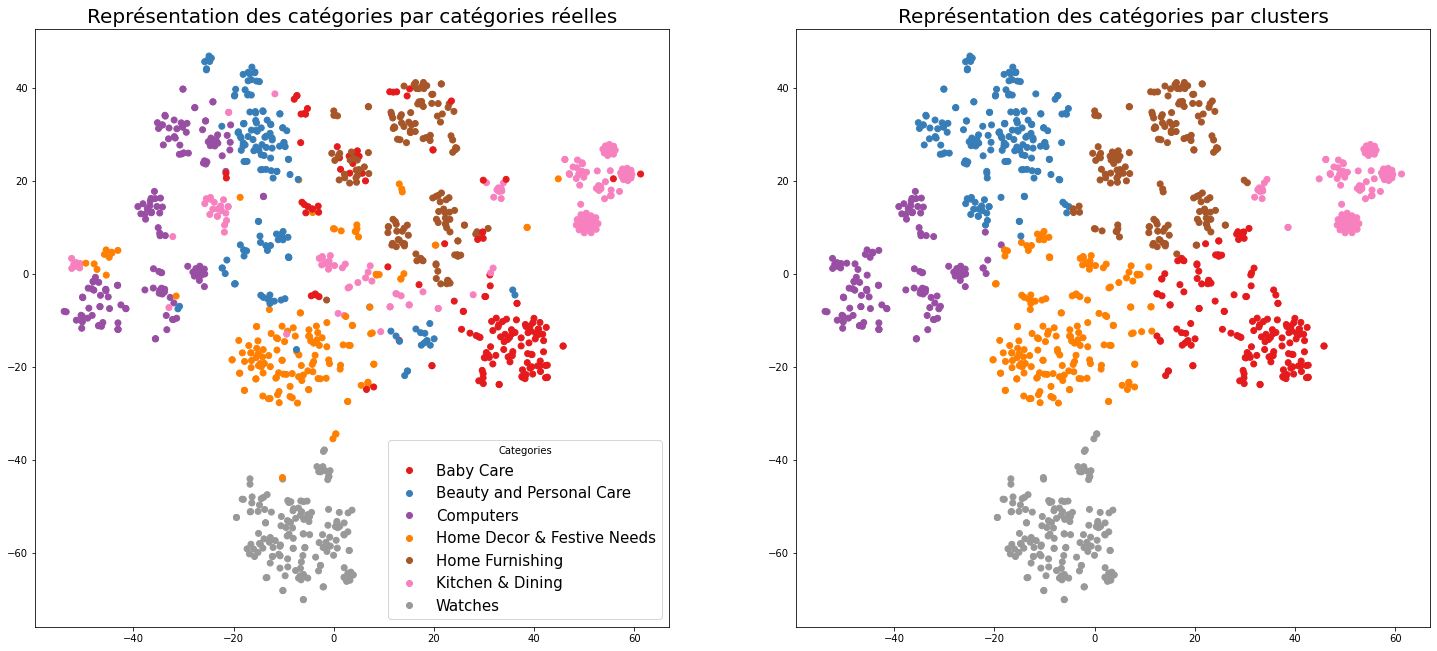

ARI :  0.5097


In [33]:
# Représentation visuelle et calcul de l'Adjusted Rand Score
ARI_tfidf = ARI_TSNE_visuel(clusters)

In [34]:
# Calcul du score de silhouette
silhouette_tfidf = round(silhouette_score(X_tsne, clusters), 4)

print('Silhouette Score de Tf-idf Vectorizer: {:.2f}'.format(silhouette_tfidf))

Silhouette Score de Tf-idf Vectorizer: 0.51


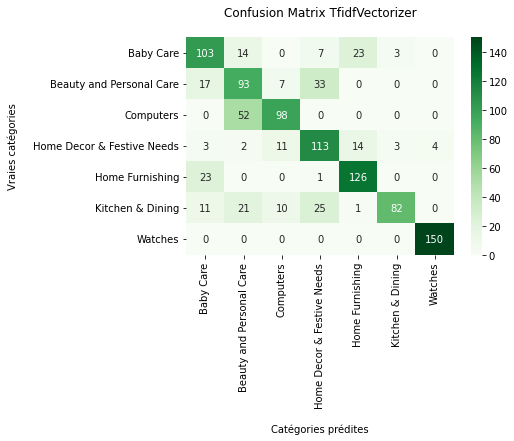

In [35]:
# Matrice de confusion pour mieux voir nos erreurs
matrix_tfidf = confusion_matrix(data['categories'], data['cluster_encoded'])

ax = sns.heatmap(matrix_tfidf, annot=True, cmap='Greens', fmt='g')

ax.set_title('Confusion Matrix TfidfVectorizer\n');
ax.set_xlabel('\nCatégories prédites')
ax.set_ylabel('Vraies catégories\n');

# On ordonne nos catégories
ax.xaxis.set_ticklabels(sorted(data['product_category_tree'].unique()), rotation=90)
ax.yaxis.set_ticklabels(sorted(data['product_category_tree'].unique()), rotation=0)

plt.show()

In [36]:
# Calcul de l'Accuracy
accuracy_tfidf = round(accuracy_score(data['categories'], data['cluster_encoded']), 4)*100

print('Accuracy de Tf-idf Vectorizer: {:.2f}%'.format(accuracy_tfidf))

Accuracy de Tf-idf Vectorizer: 72.86%


In [37]:
# On met à jour notre dictionnaire de résultats
ARI_tfidf = ARI_tfidf*100
silhouette_tfidf = silhouette_tfidf*100

dict_result.update({'Tf-idf Vectorizer' : [f'{ARI_tfidf}', f'{silhouette_tfidf}', f'{accuracy_tfidf}']})

## Word2Vec

In [38]:
# On crée une copie de notre jeu de données pour Word2Vec
data_w2v = data.copy()

Contrairement à nos essais précédent, nous allons garder les stopwords et ne pas faire de lemmatization.

In [39]:
# On garde les stopwords, on ne fait pas de lemmatization
data_w2v['sentence_word2vec'] = data_w2v['description'].apply(
    lambda x : transformation(x, del_sw=False, lem=False))

In [40]:
# Distance maximale entre le mot actuel et le mot prédit dans une phrase
w2v_window = 10

# On va utiliser tout notre vocabulaire
w2v_min_count = 1

# Nombre d'itération sur le corpus
w2v_epochs = 20

sentences = data_w2v['sentence_word2vec'].tolist()

# Preprocessing déjà réalisé, on va simplement obtenir des tokens
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

# Création et entraînement du modèle Word2Vec
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window, vector_size=200,
                                   seed=24, sg=0)

w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv

w2v_words = model_vectors.index_to_key
print("Taille du vocabulaire : %i" % len(w2v_words))

Taille du vocabulaire : 5192


Regardons les mots similaires à quelques tokens :

In [41]:
computer_token = w2v_model.wv.most_similar('computer', topn=5)
computer_token

[('vacuum', 0.9585323929786682),
 ('connect', 0.9102525115013123),
 ('keyboard', 0.9100785851478577),
 ('cleaning', 0.9062701463699341),
 ('port', 0.9026027917861938)]

Vérifions s'il est normal d'avoir de telles similités entre "computer" et "vacuum" par exemple.

In [42]:
data_vacuum = data_w2v.loc[data_w2v['sentence_word2vec'].str.contains("vacuum")]

print('Nombre de lignes :', data_vacuum.shape[0], '\n')
data_vacuum.head()

Nombre de lignes : 2 



,uniq_id,product_name,brand,product_category_tree,image,description,categories,clusters,cluster_to_cat,cluster_encoded,sentence_word2vec
451,f0d5e49c1a5aead18d5ff2e8f611de4e,Lushomes Plain Back Cushion,Lushomes,Home Furnishing,f0d5e49c1a5aead18d5ff2e8f611de4e.jpg,Key Features of Lushomes Plain Back Cushion Av...,4,2,Home Furnishing,4,key features of lushomes plain back cushion av...
589,621a88993a7033df3440ec816c2e386f,"Shopfloor.XYZ Vacuum Cleaner for Computers, La...",Shopfloor.XYZ,Computers,621a88993a7033df3440ec816c2e386f.jpg,"Shopfloor.XYZ Vacuum Cleaner for Computers, La...",2,5,Computers,2,shopfloor xyz vacuum cleaner for computers lap...


In [43]:
# Regardons la première ligne
data_vacuum.iloc[0, 10][:500]

'key features of lushomes plain back cushion available in various color options and packing combination to suit every décor need super soft and fluffy uber stylish cushions to take you from the ordinary to the extra ordinary package contents 5 cushions with fancy buttons size 16 inch x 16 inch or 40 cm x 40 cm lushomes plain back cushion pack of5 brown price rs 1 599 elevate your living with theseuberstylish cushions which come with coordinating buttons the multi tone fabric leaves the guest amaz'

On ne voit pas de lien avec des ordinateurs.

In [44]:
# Regardons la seconde ligne
data_vacuum.iloc[1, 10][:500]

'shopfloor xyz vacuum cleaner for computers laptops mobiles sf vc_011 price rs 269 requires no external power source just plugs straight into any usb port use the brush and suction tube attachment for general cleaning of air fans monitor and computer area or dust on you desktop use the keyboard attachment rubber to vacuum the dust and other particles trapped underneath the keyboard keys press the high power button to increase suction power usb computer vacuum cleaner for laptop pc keyboard simply'

Le deuxième produit avec le mot "vacuum" est un aspirateur pour ordinateur ce qui explique les similarités que l'on a pu voir.

Regardons un deuxième mot :

In [45]:
watch_token = w2v_model.wv.most_similar('watch', topn=5)
watch_token

[('men', 0.9725378751754761),
 ('nc', 0.9679569602012634),
 ('analog', 0.9591473340988159),
 ('sl', 0.9494960308074951),
 ('figh_', 0.9429230093955994)]

La plupart des mots similaires n'ayant pas de sens, il peut s'agir de marques.

In [46]:
data_w2v['brand'].fillna('Pas de marques', inplace=True)
data_w2v['brand'] = data_w2v['brand'].str.lower()

In [47]:
for value in ['ym', 'sl', 'nc']:
    occurences = data_w2v.loc[data_w2v['brand'].str.contains(value)]
    if occurences.shape[0] != 0:
        print(value, 'est bien une marque.\n')
    else:
        print(value, "n'est peut-être pas une marque.\n")

ym est bien une marque.

sl est bien une marque.

nc est bien une marque.



Tous nos mots particuliers correspondent donc à des marques. C'est donc normal de retrouver de tels tokens dans nos tokens les plus similaires à "*watch*", les marques sont toujours dans le contexte de nos mots recherchés.

A noter : nos mots les plus similaires peuvent légèrement changer à chaque fois que l'on relance notre Word2Vec. Cependant, ces mots qui n'ont pas de sens vont toujours être des marques et/ou être des acronymes habituels pour les montres. Il est donc normal de trouver de tels mots dans nos mots les plus similaires.

In [48]:
# Préparation des sentences (tokenization)

# On tokénise
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

# On va ajouter des 0 à toutes les sentences sauf la plus longue
maxlen = None

# On s'occupe du padding
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences), maxlen=maxlen, padding='post') 

Nous allons maintenant créer la matrice d'embedding.

In [49]:
# On crée une matrice vide avec les bonnes dimensions
w2v_size = model_vectors[0].shape[0]
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))

i=0
j=0

# Et on la remplit avec nos vecteurs de mot
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

# On vérifie si on obtient bien les bonnes dimensions : (5193, 200)
print("Dimensions de la matrice d'embedding : %s" % str(embedding_matrix.shape))

Dimensions de la matrice d'embedding : (5193, 200)


In [50]:
# Input layer
word_input = Input(shape=(maxlen, ), dtype='float64')
word_embedding = Embedding(input_dim=vocab_size, output_dim=w2v_size,
                           weights = [embedding_matrix], input_length=maxlen)(word_input)

# Pooling layer
word_vec=GlobalAveragePooling1D()(word_embedding)

# Création du modèle
embed_model = Model([word_input], word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 200)         1038600   
                                                                 
 global_average_pooling1d (G  (None, 200)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,038,600
Trainable params: 1,038,600
Non-trainable params: 0
_________________________________________________________________


In [51]:
# On fait nos prédictions
embeddings = embed_model.predict(x_sentences)

# On vérifie qu'on obtient bien 1050 prédictions
embeddings.shape

(1050, 200)

In [52]:
print("Word2Vec : ")
print("-----------------")

# On réduit nos dimensions et on fait un K-Means
X_tsne, clusters = reduc_clustering(embeddings)

Word2Vec : 
-----------------
Nombre de valeurs pour nos 7 clusters :
 {0: 158, 1: 165, 2: 178, 3: 134, 4: 94, 5: 79, 6: 242} 

Time : 7.0 secondes


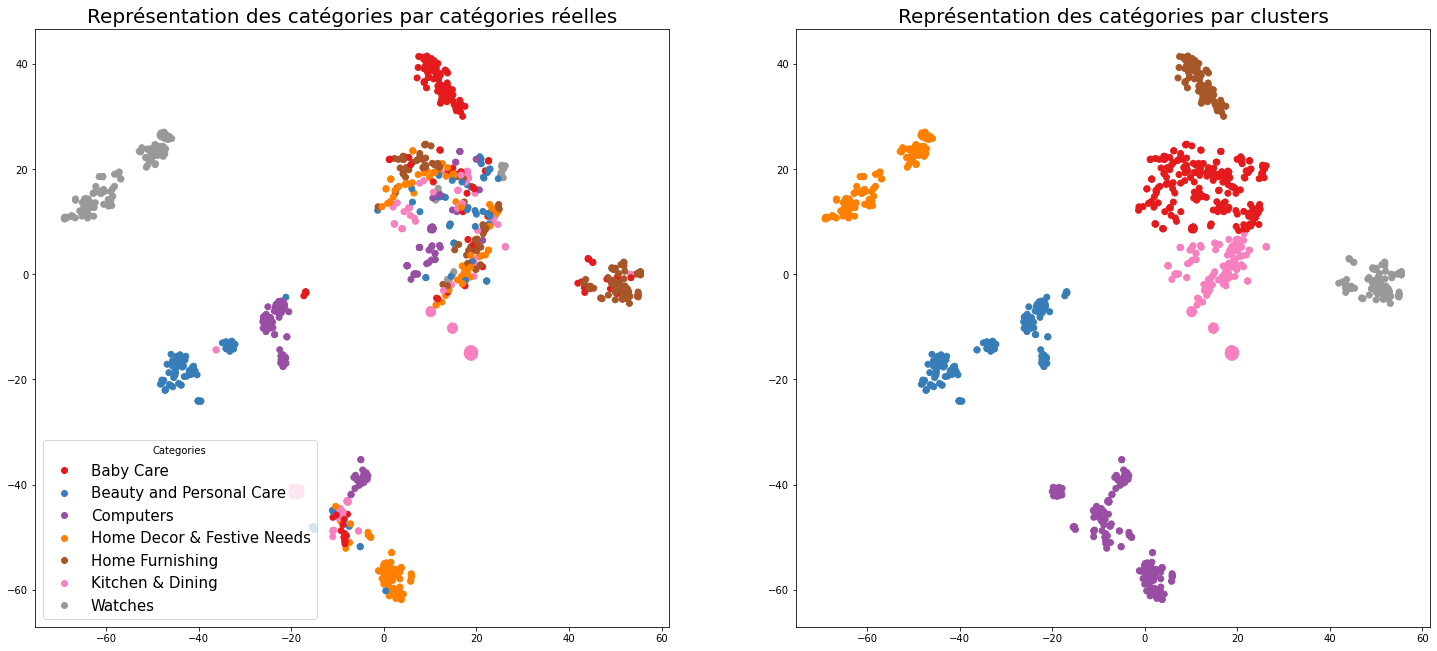

ARI :  0.2921


In [53]:
# Représentation visuelle et calcul de l'Adjusted Rand Score
ARI_w2v = ARI_TSNE_visuel(clusters)

In [54]:
# Calcul du score de silhouette
silhouette_w2v = round(silhouette_score(X_tsne, clusters), 4)

print('Silhouette Score de Word2Vec: {:.2f}'.format(silhouette_w2v))

Silhouette Score de Word2Vec: 0.60


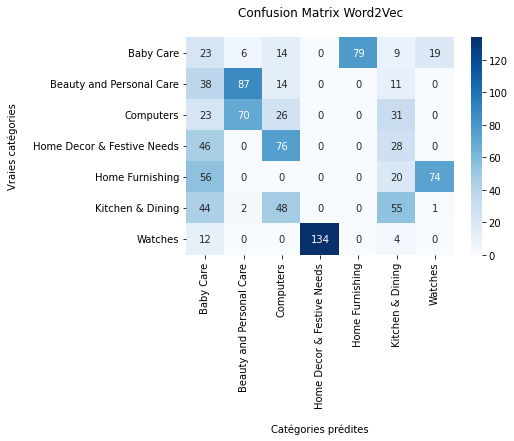

In [55]:
# Matrice de confusion pour mieux voir nos erreurs
matrix_w2v = confusion_matrix(data['categories'], data['cluster_encoded'])

ax = sns.heatmap(matrix_w2v, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix Word2Vec\n');
ax.set_xlabel('\nCatégories prédites')
ax.set_ylabel('Vraies catégories\n');

# On ordonne nos catégories
ax.xaxis.set_ticklabels(sorted(data['product_category_tree'].unique()), rotation=90)
ax.yaxis.set_ticklabels(sorted(data['product_category_tree'].unique()), rotation=0)

plt.show()

In [56]:
# Calcul de l'Accuracy
accuracy_w2v = round(accuracy_score(data['categories'], data['cluster_encoded']), 4)*100

print('Accuracy de Word2Vec: {:.2f}%'.format(accuracy_w2v))

Accuracy de Word2Vec: 18.19%


In [57]:
# On met à jour notre dictionnaire de résultats
ARI_w2v = ARI_w2v*100
silhouette_w2v = silhouette_w2v*100

dict_result.update({'Word2Vec' : [f'{ARI_w2v}', f'{silhouette_w2v}', f'{accuracy_w2v}']})

# Universal Sentence Encoder

In [58]:
# On charge le module USE de Tensorflow
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [59]:
# On crée une copie de notre jeu de données initial
data_use = data.copy()

# On garde les stopwords, on ne fait pas de lemmatization
data_use['sentence_use'] = data_use['description'].apply(
    lambda x : transformation(x, del_sw=False, lem=False))

sentences = data_use['sentence_use'].to_list()

In [60]:
# On lance le modèle
batch_size = 105
features_USE = feature_USE_fct(sentences, batch_size)

In [61]:
print("Universal Sentence Encoder : ")
print("-----------------")

# On réduit nos dimensions et on fait un K-Means
X_tsne, clusters = reduc_clustering(features_USE)

Universal Sentence Encoder : 
-----------------
Nombre de valeurs pour nos 7 clusters :
 {0: 127, 1: 211, 2: 88, 3: 156, 4: 146, 5: 164, 6: 158} 

Time : 8.0 secondes


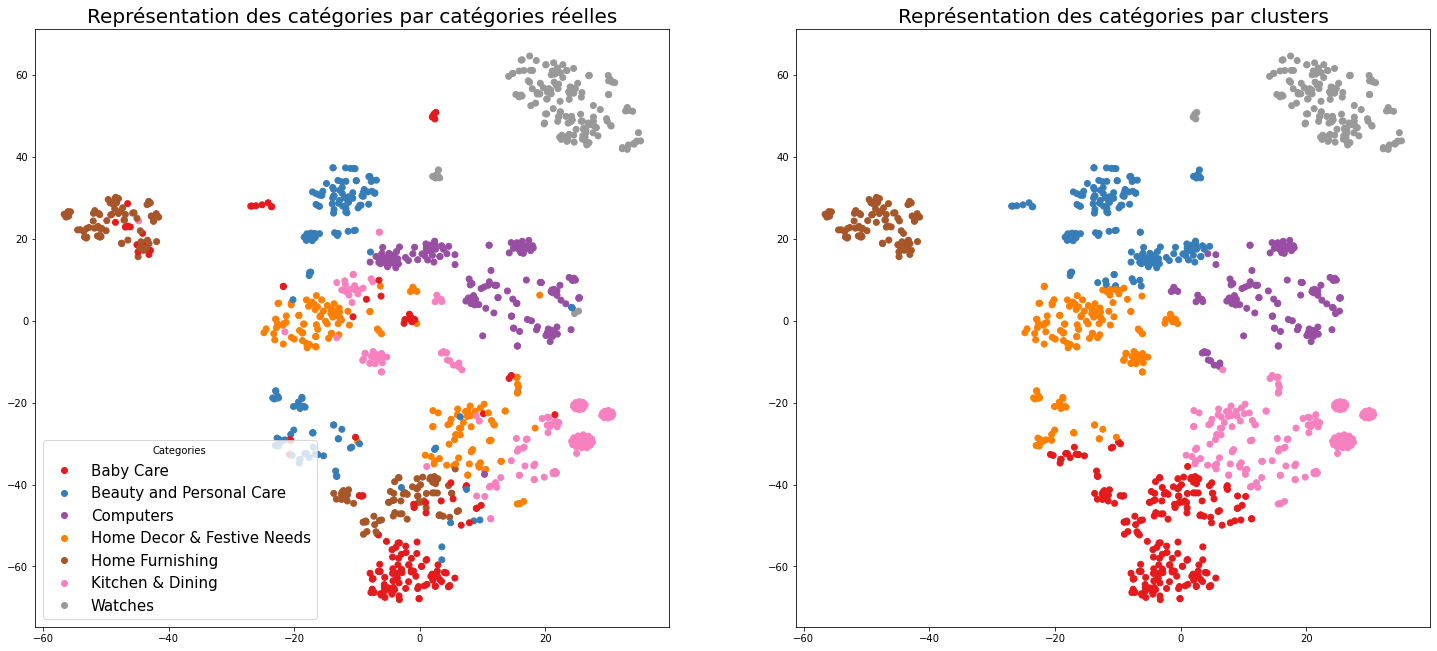

ARI :  0.4255


In [62]:
# Représentation visuelle et calcul de l'Adjusted Rand Score
ARI_use = ARI_TSNE_visuel(clusters)

In [63]:
# Calcul du score de silhouette
silhouette_use = round(silhouette_score(X_tsne, clusters), 4)

print('Silhouette Score de USE: {:.2f}'.format(silhouette_use))

Silhouette Score de USE: 0.53


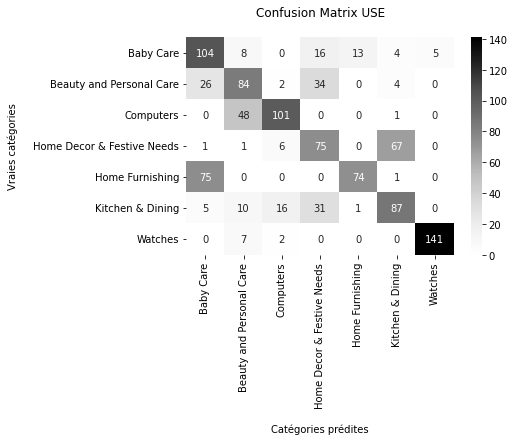

In [64]:
# Matrice de confusion pour mieux voir nos erreurs
matrix_use = confusion_matrix(data['categories'], data['cluster_encoded'])

ax = sns.heatmap(matrix_use, annot=True, cmap='Greys', fmt='g')

ax.set_title('Confusion Matrix USE\n');
ax.set_xlabel('\nCatégories prédites')
ax.set_ylabel('Vraies catégories\n');

# On ordonne nos catégories
ax.xaxis.set_ticklabels(sorted(data['product_category_tree'].unique()), rotation=90)
ax.yaxis.set_ticklabels(sorted(data['product_category_tree'].unique()), rotation=0)

plt.show()

In [65]:
# Calcul de l'Accuracy
accuracy_use = round(accuracy_score(data['categories'], data['cluster_encoded']), 4)*100

print('Accuracy de USE: {:.2f}%'.format(silhouette_count))

Accuracy de USE: 44.40%


In [66]:
# On met à jour notre dictionnaire de résultats
ARI_use = ARI_use*100
silhouette_use = silhouette_use*100

dict_result.update({'Universal Sentence Encoder' : [f'{ARI_use}', f'{silhouette_use}', f'{accuracy_use}']})

## Bert (Tensorflow - 12 couches)

In [67]:
# On crée une copie de notre jeu de données initial
data_bert = data.copy()

# On garde les stopwords, on ne fait pas de lemmatization
data_bert['sentence_bert'] = data_bert['description'].apply(
    lambda x : transformation(x, del_sw=False, lem=False))

Nous allons regarder la taille de nos phrases pour déterminer une bonne valeur pour notre variable max_length pour BERT.

In [68]:
# Cherchons une bonne valeur de max_length
data_bert['max_length'] = data_bert['sentence_bert']

for value in range(0, len(sentences)):
    data_bert['max_length'][value] = len(data_bert['max_length'][value].split())

moyenne : 77.68
médiane : 43.5
mode : 0    31
dtype: object


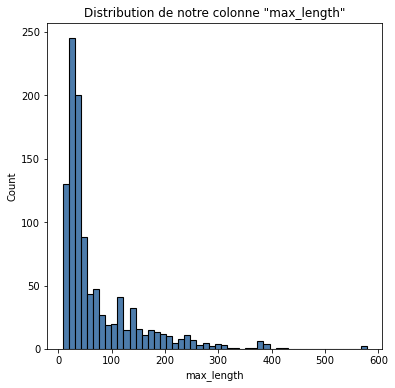

In [69]:
print('moyenne :', round(data_bert['max_length'].mean(), 2))
print('médiane :', round(data_bert['max_length'].median(), 2))
print('mode :', data_bert['max_length'].mode())

# Histrogramme de la distribution de la variable
plt.figure(figsize = (6, 6))
plt.hist(x = data_bert['max_length'].values, bins = 50, align = 'left', color = '#4d7cab',
         edgecolor = 'black', linewidth = 1.1)
plt.title('Distribution de notre colonne "max_length"')
plt.xlabel('max_length')
plt.ylabel('Count')
plt.show()

In [70]:
# On va prendre la moyenne entre la médiane et le mode
max_length = round(np.mean([data_bert['max_length'].median(), data_bert['max_length'].mode()[0]]))

In [71]:
# On charge le modèle BERT (12 couches)
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

# On prépare nos phrases
sentences = data_bert['sentence_bert'].to_list()

In [72]:
batch_size = 105
model_type = 'bert-base-uncased'
model = bert_layer

# On lance le modèle
features_bert = feature_BERT_fct(model, model_type, sentences, max_length, batch_size)

temps traitement :  34.0


In [73]:
print("Bert : ")
print("-----------------")

# On réduit nos dimensions et on fait un K-Means
X_tsne, clusters = reduc_clustering(features_bert)

Bert : 
-----------------
Nombre de valeurs pour nos 7 clusters :
 {0: 163, 1: 195, 2: 212, 3: 91, 4: 148, 5: 152, 6: 89} 

Time : 7.0 secondes


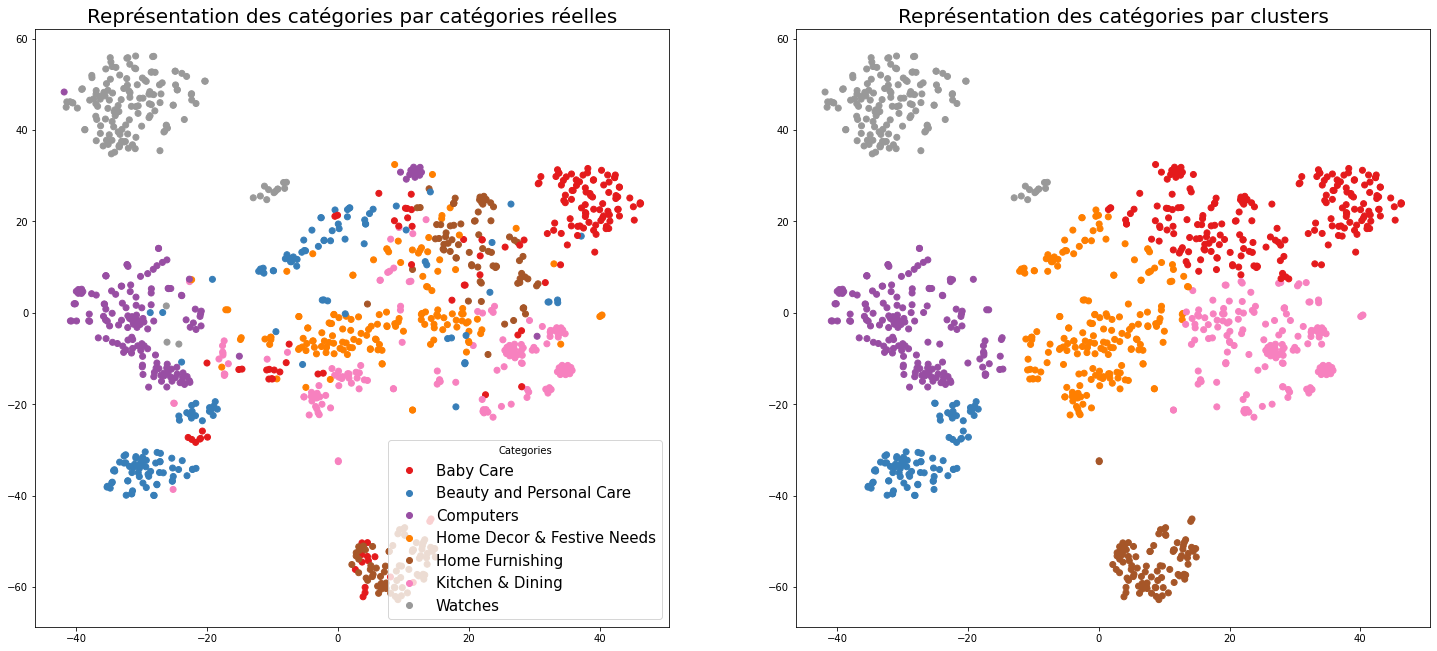

ARI :  0.4492


In [74]:
# Représentation visuelle et calcul de l'Adjusted Rand Score
ARI_bert = ARI_TSNE_visuel(clusters)

In [75]:
# Calcul du score de silhouette
silhouette_bert = round(silhouette_score(X_tsne, clusters), 4)

print('Silhouette Score de BERT : {:.2f}'.format(silhouette_bert))

Silhouette Score de BERT : 0.52


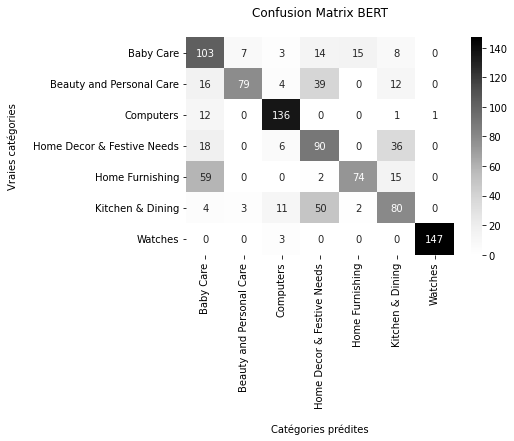

In [76]:
# Matrice de confusion pour mieux voir nos erreurs
matrix_bert = confusion_matrix(data['categories'], data['cluster_encoded'])

ax = sns.heatmap(matrix_bert, annot=True, cmap='Greys', fmt='g')

ax.set_title('Confusion Matrix BERT\n');
ax.set_xlabel('\nCatégories prédites')
ax.set_ylabel('Vraies catégories\n');

# On ordonne nos catégories
ax.xaxis.set_ticklabels(sorted(data['product_category_tree'].unique()), rotation=90)
ax.yaxis.set_ticklabels(sorted(data['product_category_tree'].unique()), rotation=0)

plt.show()

In [77]:
# Calcul de l'Accuracy
accuracy_bert = round(accuracy_score(data['categories'], data['cluster_encoded']), 4)*100

print('Accuracy de Bert : {:.2f}%'.format(accuracy_bert))

Accuracy de Bert : 67.52%


In [78]:
# On met à jour notre dictionnaire de résultats
ARI_bert = ARI_bert*100
silhouette_bert = silhouette_bert*100

dict_result.update({'Bert' : [f'{ARI_bert}', f'{silhouette_bert}', f'{accuracy_bert}']})

# Clustering via les images de nos articles

# CNN avec Transfer Learning

On doit commencer par organiser nos images par catégories.

In [79]:
# import shutil

# sub_list = data['product_category_tree'].unique()

# #creating subfolders
# for i in sub_list:
#     os.makedirs(os.path.join('P6_Images_cat', i))

# #moving the image files to their respective categories
# for c in sub_list: # Category Name
#     for i in list(data[data['product_category_tree']==c]['image']): # Image Id
#         get_image = os.path.join('P6_Images', i) # Path to Images 
#         move_image_to_cat = shutil.move(get_image, 'P6_Images_cat/'+c)

In [80]:
# On récupère nos images
path = r'C:\Users\victo\P6_Images_cat'

dataset = tf.keras.utils.image_dataset_from_directory(path, labels='inferred', color_mode='rgb',
                                                      shuffle=False, image_size=(224, 224))

Found 1050 files belonging to 7 classes.


In [81]:
# On vérifie nos catégories
class_names = dataset.class_names
class_names

['Baby Care',
 'Beauty and Personal Care',
 'Computers',
 'Home Decor & Festive Needs',
 'Home Furnishing',
 'Kitchen & Dining',
 'Watches']

In [82]:
# Prefetching pour améliorer les performances
AUTOTUNE = tf.data.AUTOTUNE

dataset = dataset.prefetch(buffer_size=AUTOTUNE)

In [83]:
# On n'a peu de données, on va faire de la data augmentation
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),
                                         tf.keras.layers.RandomRotation(0.2)])

In [84]:
# On va utiliser le preprocess propre à vgg16
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [85]:
# On charge le modèle pré-entraîné
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [86]:
# On va extraire les features, on n'entraîne pas les couches les plus hautes
for layer in model.layers:
    layer.trainable = False

In [87]:
# On regarde notre modèle
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [88]:
# On ajoute une couche de pooling et on change la dernière couche
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(7, activation='softmax')

In [89]:
# On crée notre nouveau modèle
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
new_model = tf.keras.Model(inputs, outputs)

In [90]:
# On compile
new_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

In [91]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                    

In [92]:
# On fit
new_model_info = new_model.fit(dataset, epochs=15, batch_size=105, verbose=2)

Epoch 1/15
33/33 - 79s - loss: 18.5825 - sparse_categorical_accuracy: 0.1190 - 79s/epoch - 2s/step
Epoch 2/15
33/33 - 77s - loss: 9.3305 - sparse_categorical_accuracy: 0.1505 - 77s/epoch - 2s/step
Epoch 3/15
33/33 - 76s - loss: 7.3319 - sparse_categorical_accuracy: 0.2400 - 76s/epoch - 2s/step
Epoch 4/15
33/33 - 77s - loss: 5.4931 - sparse_categorical_accuracy: 0.3124 - 77s/epoch - 2s/step
Epoch 5/15
33/33 - 77s - loss: 4.8872 - sparse_categorical_accuracy: 0.3857 - 77s/epoch - 2s/step
Epoch 6/15
33/33 - 77s - loss: 4.1973 - sparse_categorical_accuracy: 0.4562 - 77s/epoch - 2s/step
Epoch 7/15
33/33 - 77s - loss: 3.5189 - sparse_categorical_accuracy: 0.5038 - 77s/epoch - 2s/step
Epoch 8/15
33/33 - 77s - loss: 3.1643 - sparse_categorical_accuracy: 0.5419 - 77s/epoch - 2s/step
Epoch 9/15
33/33 - 76s - loss: 3.1067 - sparse_categorical_accuracy: 0.5638 - 76s/epoch - 2s/step
Epoch 10/15
33/33 - 77s - loss: 2.6631 - sparse_categorical_accuracy: 0.5962 - 77s/epoch - 2s/step
Epoch 11/15
33/33 

In [93]:
# On essaie de prédire nos catégories
predictions = new_model.predict(dataset, batch_size=105, verbose=2)

33/33 - 76s - 76s/epoch - 2s/step


In [94]:
# On garde la probabilité la plus haute de chacune de nos predictions
clusters = []

for i in range(predictions.shape[0]):
    cluster = np.where(predictions[i] == predictions[i].max())
    clusters.append(int(cluster[0]))

In [95]:
# On ordonne nos données alphabétiquement et selon les catégories
data.sort_values(['product_category_tree', 'uniq_id'], ascending=True, inplace=True)

In [96]:
# On associe la valeur de nos clusters à leur catégorie
data['clusters'] = clusters
    
list_cluster_to_cat = []

for cat in l_cat:
    sub_df = data[['product_category_tree', 'clusters']]
    category = sub_df[sub_df['product_category_tree'] == cat].value_counts()
    list_cluster_to_cat.append(category.index[0])

list_cluster_to_cat = sorted(list_cluster_to_cat, key=lambda tup: tup[1])

list_test = []

for row in data.index:
    for i in range(7):
        if data.loc[row, 'clusters'] == i:
            list_test.append(list_cluster_to_cat[i][0])
    
data['cluster_to_cat'] = list_test
    
data['cluster_encoded'] = labelencoder.transform(data['cluster_to_cat'])
    
labels = data['cluster_encoded']

In [97]:
# Et on calcule l'ARI
ARI_cnn = np.round(adjusted_rand_score(data['product_category_tree'], data['cluster_to_cat']), 4)
print('ARI :', ARI_cnn)

ARI : 0.643


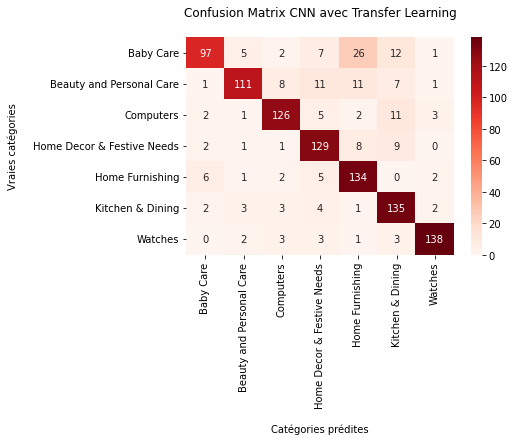

In [98]:
# Matrice de confusion pour mieux voir nos erreurs
matrix_cnn = confusion_matrix(data['categories'], data['cluster_encoded'])

ax = sns.heatmap(matrix_cnn, annot=True, cmap='Reds', fmt='g')

ax.set_title('Confusion Matrix CNN avec Transfer Learning\n');
ax.set_xlabel('\nCatégories prédites')
ax.set_ylabel('Vraies catégories\n');

# On ordonne nos catégories
ax.xaxis.set_ticklabels(sorted(data['product_category_tree'].unique()), rotation=90)
ax.yaxis.set_ticklabels(sorted(data['product_category_tree'].unique()), rotation=0)

plt.show()

In [99]:
# Calcul de l'Accuracy
accuracy_cnn = round(accuracy_score(data['categories'], data['cluster_encoded']), 4)*100

print('Accuracy du CNN avec Transfer Learning : {:.2f}%'.format(accuracy_cnn))

Accuracy du CNN avec Transfer Learning : 82.86%


In [100]:
# On met à jour notre dictionnaire de résultats
ARI_cnn = ARI_cnn*100
silhouette_cnn = 0

dict_result.update({'CNN - Transfer Learning' : [f'{ARI_cnn}', f'{silhouette_cnn}', f'{accuracy_cnn}']})

## ORB

In [101]:
# On crée une liste de nos photos
path = "P6_Images"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


On doit réordonner nos données pour avoir le même ordre dans notre dossier avec toutes les images et dans le dataframe.

In [102]:
# On réordonne
data.set_index('image', inplace=True)
data = data.reindex(list_photos)
data = data.reset_index()

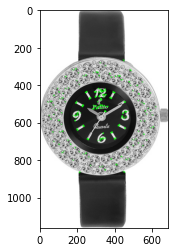

In [103]:
# Premier test en mettant l'image en noir et blanc
img = cv2.imread(path + '/' + list_photos[0], 0)

# On crée le modèle
orb = cv2.ORB_create()

# On trouve les keypoints avec ORB
kp = orb.detect(img, None)

# Et les descripteurs
kp, des = orb.compute(img, kp)

# On indique les keypoints sur l'image
img2 = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)

plt.imshow(img2)
plt.show()

In [104]:
# On va créer une liste qui va reprendre les descripteurs de chacune de nos images
list_descriptors=[]
orb = cv2.ORB_create(nfeatures=750)

# Même principe que précédemment mais pour toutes les images
for image in range(len(list_photos)):
    im = cv2.imread(path + '/' + list_photos[image], 3)
    kp = orb.detect(im, None)
    keypoints, descriptor = orb.compute(im, kp)
    list_descriptors.append(descriptor)

On va devoir supprimer une image en particulier pour qui on ne trouve pas de descripteurs. Sans cette suppression, on aurait une erreur lors de la concaténation de notre liste de descripteurs. On affiche l'image pour information.

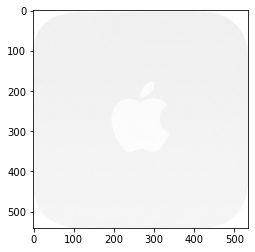

In [105]:
img = cv2.imread(path + '/' + list_photos[635], 0)
orb = cv2.ORB_create()
kp = orb.detect(img, None)
kp, des = orb.compute(img, kp)
img2 = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)
plt.imshow(img2)
plt.show()

In [106]:
# Nom de la photo problématique
list_photos[635]

'9743e6d1c9f3180483825fe4d2e97836.jpg'

In [107]:
# On doit supprimer l'image à l'index 635
del list_descriptors[635]

# Et on doit aussi supprimer dans le dataframe
i = data[(data['image'] == '9743e6d1c9f3180483825fe4d2e97836.jpg')].index
data = data.drop(i)

In [108]:
# On crée une array de descripteurs
array_descriptors = np.asarray(list_descriptors, dtype=object)

# Et on concatène notre liste de descripteurs
list_descriptors_all = np.concatenate(list_descriptors, axis=0)
list_descriptors_all.shape

(743782, 32)

On utilise MiniBacthKMeans pour réduire les temps de calcul. On va utiliser la racine du nombre de descripteurs (743 782) pour estimer le nombre de clusters.

In [109]:
k = int(round(np.sqrt(len(list_descriptors_all)), 0))
print("Nombre de clusters estimés : ", k)

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=24, batch_size=4096)
kmeans.fit(list_descriptors_all)

Nombre de clusters estimés :  862


MiniBatchKMeans(batch_size=4096, init_size=2586, n_clusters=862,
                random_state=24)

On va créer une matrice d'histogrammes. Ces histogrammes representent le nombre de descripteurs dans chaque clusters pour chaque image.

In [110]:
# On crée nos histogrammes
hist_vectors=[]

for i, image_desc in enumerate(array_descriptors) :
    hist = build_histogram(kmeans, image_desc, i)
    hist_vectors.append(hist)

# On obtient les features que l'on va pouvoir utiliser
im_features = np.asarray(hist_vectors)

In [111]:
# Pour information
im_features.shape

(1049, 862)

In [112]:
print("ORB : ")
print("-----------------")

# On réduit nos dimensions et on fait un K-Means
X_tsne, clusters = reduc_clustering(im_features)

ORB : 
-----------------
Nombre de valeurs pour nos 7 clusters :
 {0: 127, 1: 165, 2: 128, 3: 141, 4: 173, 5: 145, 6: 170} 

Time : 7.0 secondes


Dans la mesure où nous avons supprimer une image, nous devons redéfinir notre variable *y_cat_num*.

In [113]:
y_cat_num = data['categories']

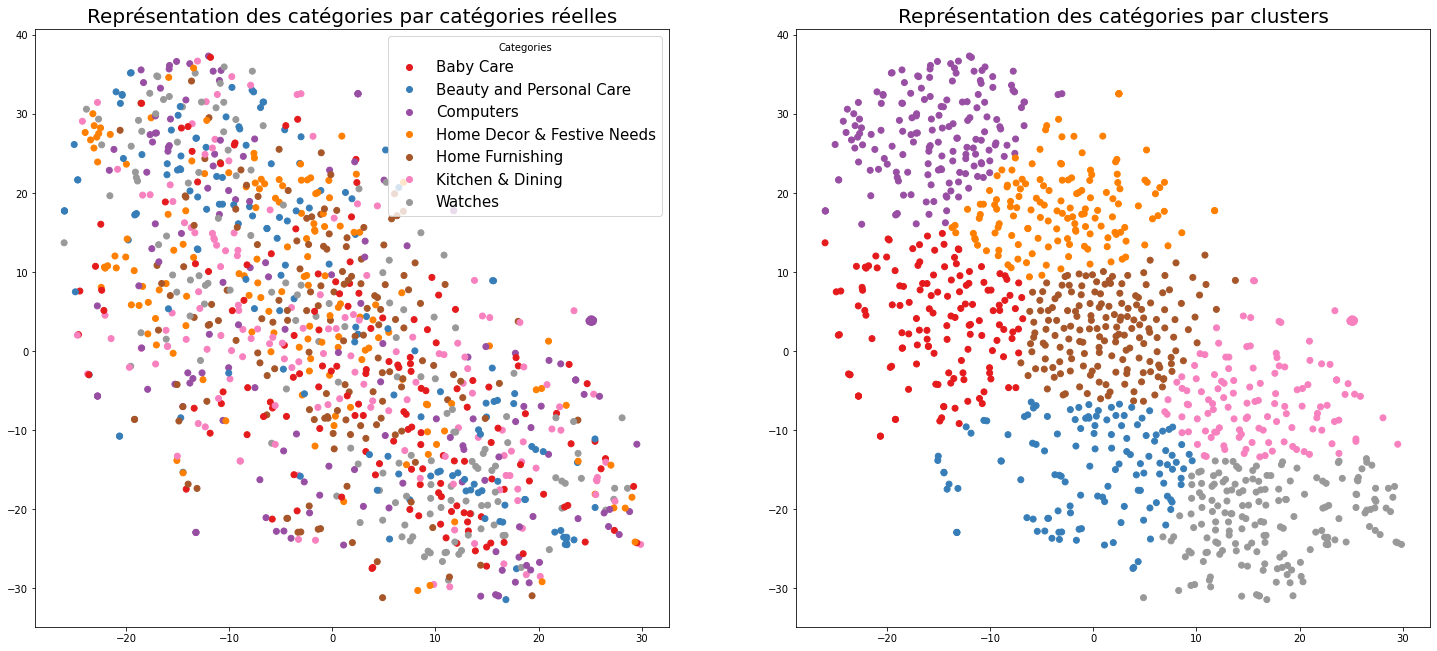

ARI :  0.0314


In [114]:
# Représentation visuelle et calcul de l'Adjusted Rand Score
ARI_orb = ARI_TSNE_visuel(clusters)

In [115]:
# Calcul du score de silhouette
silhouette_orb = round(silhouette_score(X_tsne, clusters), 4)

print('Silhouette Score de ORB: {:.2f}'.format(silhouette_orb))

Silhouette Score de ORB: 0.36


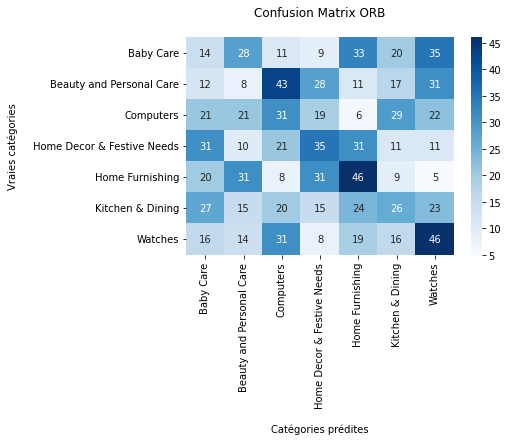

In [116]:
# Matrice de confusion pour mieux voir nos erreurs
matrix_orb = confusion_matrix(data['categories'], data['cluster_encoded'])

ax = sns.heatmap(matrix_orb, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix ORB\n');
ax.set_xlabel('\nCatégories prédites')
ax.set_ylabel('Vraies catégories\n');

# On ordonne nos catégories
ax.xaxis.set_ticklabels(sorted(data['product_category_tree'].unique()), rotation=90)
ax.yaxis.set_ticklabels(sorted(data['product_category_tree'].unique()), rotation=0)

plt.show()

In [117]:
# Calcul de l'Accuracy
accuracy_orb = round(accuracy_score(data['categories'], data['cluster_encoded']), 4)*100

print('Accuracy de ORB : {:.2f}%'.format(accuracy_orb))

Accuracy de ORB : 19.64%


In [118]:
# On met à jour notre dictionnaire de résultats
ARI_orb = ARI_orb*100
silhouette_orb = silhouette_orb*100

dict_result.update({'ORB' : [f'{ARI_orb}', f'{silhouette_orb}', f'{accuracy_orb}']})

# Résultats de nos analyses :

In [119]:
# On crée un dictionnaire qui va reprendre tous nos résultats
df_result = pd.DataFrame.from_dict(dict_result, orient = 'index', columns = ['ARI', 'Silhouette', 'Accuracy'])

In [120]:
# On s'assure que nos données sont bien numériques
for col in df_result.columns:
    df_result[col] = pd.to_numeric(df_result[col])

In [121]:
# On ordonne nos données
df_result.sort_values('ARI', ascending=False, inplace=True)

In [122]:
df_result.head(8)

,ARI,Silhouette,Accuracy
CNN - Transfer Learning,64.30,0.000000,82.86
Tf-idf Vectorizer,50.97,51.410002,72.86
Bert,44.92,52.069998,67.52
Universal Sentence Encoder,42.55,52.660000,63.43
CountVectorizer,42.02,44.400001,68.86
Word2Vec,29.21,60.399997,18.19
ORB,3.14,36.240000,19.64


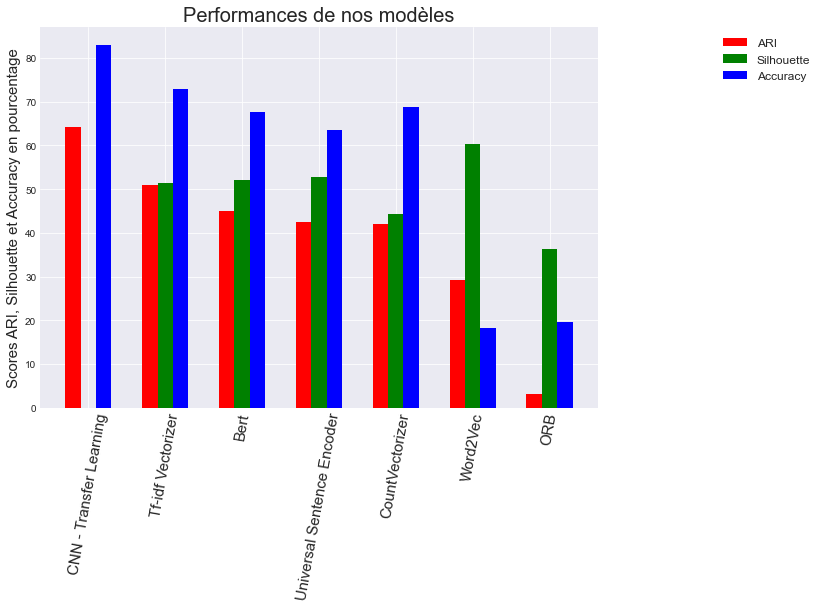

In [123]:
# Représentation graphique de nos résultats
x = df_result.index
y = df_result["ARI"]
z = df_result['Silhouette']
u = df_result['Accuracy']

_x = np.arange(len(x))

fig = plt.figure(figsize=(10, 7))

plt.style.use('seaborn-darkgrid')
plt.bar(_x-0.2, y, 0.2, color = 'r', align = 'center')
plt.bar(_x, z, 0.2, color = 'g', align = 'center')
plt.bar(_x+0.2, u, 0.2, color = 'b', align = 'center')
plt.xticks(_x, x, rotation = 80, fontsize = 15)
plt.ylabel('Scores ARI, Silhouette et Accuracy en pourcentage', fontsize = 15)

plt.title('Performances de nos modèles', fontsize = 20)
plt.legend(['ARI', 'Silhouette', 'Accuracy'], bbox_to_anchor = (1.4, 1.), fontsize = 12)

plt.show()